https://towardsdatascience.com/encoder-decoder-model-for-multistep-time-series-forecasting-using-pytorch-5d54c6af6e60

https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/43795

https://github.com/Arturus/kaggle-web-traffic



## Clone GIT, install requirements

In [1]:
# https://github.com/Mykrass/pytorch-ts.git
!git clone https://github.com/Mykrass/pytorch-ts.git

Cloning into 'pytorch-ts'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 68 (delta 25), reused 58 (delta 21), pack-reused 0
Unpacking objects: 100% (68/68), done.


In [2]:
!ls -GFlash --color ./pytorch-ts/

total 6.0M
4.0K drwxr-xr-x 6 root 4.0K Aug 12 06:05  ./
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:05  ../
4.0K drwxr-xr-x 8 root 4.0K Aug 12 06:05  .git/
4.0K -rw-r--r-- 1 root 1.9K Aug 12 06:05  .gitignore
6.0M -rw-r--r-- 1 root 6.0M Aug 12 06:05 'item sales forecasting.ipynb'
 12K -rw-r--r-- 1 root  12K Aug 12 06:05  LICENSE.txt
4.0K -rw-r--r-- 1 root   89 Aug 12 06:05  README.md
4.0K -rw-r--r-- 1 root   43 Aug 12 06:05  requirements.txt
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05  torch_utils/
4.0K drwxr-xr-x 3 root 4.0K Aug 12 06:05  ts_models/
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05  ts_utils/


In [3]:
#
!pip install -r ./pytorch-ts/requirements.txt

     |████████████████████████████████| 59 kB 4.6 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [4]:
#!pip install plotly_express

In [5]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import plotly_express as px

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

## Data Preprocessing

https://www.kaggle.com/c/demand-forecasting-kernels-only/data

In [6]:
## Настраиваем Kaggle API
#from google.colab import files
#file = files.upload()
#
!wget https://www.dropbox.com/s/biml41fn4fbtaeu/kaggle.json
#
# Копируем токен в каталог .kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

# Загружаем данные с сайта Kaggle
#!kaggle competitions download -c web-traffic-time-series-forecasting
!kaggle competitions download -c demand-forecasting-kernels-only

--2021-08-12 06:05:37--  https://www.dropbox.com/s/biml41fn4fbtaeu/kaggle.json
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/biml41fn4fbtaeu/kaggle.json [following]
--2021-08-12 06:05:38--  https://www.dropbox.com/s/raw/biml41fn4fbtaeu/kaggle.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe4697ee233a18ee902721d8d4.dl.dropboxusercontent.com/cd/0/inline/BUFRtsR3jeqXo-6wX0m6r47wRu3lmO3giQuI9ctCYRAFkQvht4aWZafw8ayBoEdV52g6SAQSycbbN_qHgr0aCn1n7zpIv34T8GPf6DK-WATDyOdzdvzsXCLPixj2FpKghVgfwo3KN8Vg66MjDkGuOe0Y/file# [following]
--2021-08-12 06:05:39--  https://ucbe4697ee233a18ee902721d8d4.dl.dropboxusercontent.com/cd/0/inline/BUFRtsR3jeqXo-6wX0m6r47wRu3lmO3giQuI9ctCYRAFkQvht4aWZafw8ayBoEdV52g6SAQSycbbN_qHgr0aCn1n7zp

In [7]:
!ls -GFlash --color ./

total 4.4M
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:05 ./
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:03 ../
4.0K drwxr-xr-x 4 root 4.0K Jul 16 13:19 .config/
4.0K drwxr-xr-x 6 root 4.0K Aug 12 06:05 pytorch-ts/
4.0K drwxr-xr-x 1 root 4.0K Jul 16 13:20 sample_data/
388K -rw-r--r-- 1 root 385K Aug 12 06:05 sample_submission.csv
956K -rw-r--r-- 1 root 953K Aug 12 06:05 test.csv
3.1M -rw-r--r-- 1 root 3.1M Aug 12 06:05 train.csv.zip


In [8]:
#
!mkdir data
!unzip ./*.csv.zip -d ./data
!mv ./test.csv ./data
!ls -GFlash --color ./data

Archive:  ./train.csv.zip
  inflating: ./data/train.csv        
total 18M
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05 ./
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:05 ../
956K -rw-r--r-- 1 root 953K Aug 12 06:05 test.csv
 17M -rw-r--r-- 1 root  17M Dec 15  2019 train.csv


In [9]:
!head ./data/train.csv

date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [10]:
!head ./data/test.csv

id,date,store,item
0,2018-01-01,1,1
1,2018-01-02,1,1
2,2018-01-03,1,1
3,2018-01-04,1,1
4,2018-01-05,1,1
5,2018-01-06,1,1
6,2018-01-07,1,1
7,2018-01-08,1,1
8,2018-01-09,1,1


In [11]:
# READ FULL DATA
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train = train[train['store']<=5] # my possible to increase data
test = test[test['store']<=5] # my possible to increase data
print(train.shape)
print(test.shape)

(456500, 4)
(22500, 4)


In [12]:
from collections import Counter
Counter(train['store'])

Counter({1: 91300, 2: 91300, 3: 91300, 4: 91300, 5: 91300})

In [13]:
from collections import Counter
Counter(test['store'])

Counter({1: 4500, 2: 4500, 3: 4500, 4: 4500, 5: 4500})

In [14]:
train.describe()

,store,item,sales
count,456500.000000,456500.000000,456500.000000
mean,3.000000,25.500000,53.701051
std,1.414215,14.430885,29.106371
min,1.000000,1.000000,1.000000
25%,2.000000,13.000000,31.000000
50%,3.000000,25.500000,49.000000
75%,4.000000,38.000000,71.000000
max,5.000000,50.000000,231.000000


In [15]:
print(train.shape)
train.head()

(456500, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [16]:
print(test.shape)
test.head()

(22500, 4)


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [17]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [18]:
print(train['date'].min(), train['date'].max())
print(test['date'].min(), test['date'].max())

2013-01-01 00:00:00 2017-12-31 00:00:00
2018-01-01 00:00:00 2018-03-31 00:00:00


In [19]:
test['sales'] = np.nan
data = pd.concat([train, test], ignore_index=True)
data['store_item_id'] = data['store'].astype(str) + '_' + data['item'].astype(str)
data

,date,store,item,sales,id,store_item_id
0,2013-01-01,1,1,13.0,NaN,1_1
1,2013-01-02,1,1,11.0,NaN,1_1
2,2013-01-03,1,1,14.0,NaN,1_1
3,2013-01-04,1,1,13.0,NaN,1_1
4,2013-01-05,1,1,10.0,NaN,1_1
...,...,...,...,...,...,...
478995,2018-03-27,5,50,NaN,44545.0,5_50
478996,2018-03-28,5,50,NaN,44546.0,5_50
478997,2018-03-29,5,50,NaN,44547.0,5_50
478998,2018-03-30,5,50,NaN,44548.0,5_50


In [20]:
#
print(data['date'].min(), data['date'].max())

2013-01-01 00:00:00 2018-03-31 00:00:00


In [21]:
data['store_item_id'].describe()

count     479000
unique       250
top         4_21
freq        1916
Name: store_item_id, dtype: object

In [22]:
data['dayofweek'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['day'] = data['date'].dt.day
data

,date,store,item,sales,id,store_item_id,dayofweek,month,year,day
0,2013-01-01,1,1,13.0,NaN,1_1,1,1,2013,1
1,2013-01-02,1,1,11.0,NaN,1_1,2,1,2013,2
2,2013-01-03,1,1,14.0,NaN,1_1,3,1,2013,3
3,2013-01-04,1,1,13.0,NaN,1_1,4,1,2013,4
4,2013-01-05,1,1,10.0,NaN,1_1,5,1,2013,5
...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,50,NaN,44545.0,5_50,1,3,2018,27
478996,2018-03-28,5,50,NaN,44546.0,5_50,2,3,2018,28
478997,2018-03-29,5,50,NaN,44547.0,5_50,3,3,2018,29
478998,2018-03-30,5,50,NaN,44548.0,5_50,4,3,2018,30


In [23]:
data['year'].min(), data['year'].max()

(2013, 2018)

In [24]:
data['year_mod'] = (data['year'] - data['year'].min()) / (data['year'].max() - data['year'].min())
data[:3]

,date,store,item,sales,id,store_item_id,dayofweek,month,year,day,year_mod
0,2013-01-01,1,1,13.0,NaN,1_1,1,1,2013,1,0.0
1,2013-01-02,1,1,11.0,NaN,1_1,2,1,2013,2,0.0
2,2013-01-03,1,1,14.0,NaN,1_1,3,1,2013,3,0.0


In [25]:
# https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/

def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [26]:
data['dayofweek_sin'] = sin_transform(data['dayofweek'])
data['dayofweek_cos'] = cos_transform(data['dayofweek'])
data['month_sin'] = sin_transform(data['month'])
data['month_cos'] = cos_transform(data['month'])
data['day_sin'] = sin_transform(data['day'])
data['day_cos'] = cos_transform(data['day'])
data[:3]

,date,store,item,sales,id,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos
0,2013-01-01,1,1,13.0,NaN,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,0.866025,0.201299,0.979530
1,2013-01-02,1,1,11.0,NaN,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,0.866025,0.394356,0.918958
2,2013-01-03,1,1,14.0,NaN,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,0.866025,0.571268,0.820763


In [27]:
data.drop('id', axis=1, inplace=True)

In [28]:
data = data.sort_values(['store_item_id', 'date'])
data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos
0,2013-01-01,1,1,13.0,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,8.660254e-01,2.012985e-01,0.979530
1,2013-01-02,1,1,11.0,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,8.660254e-01,3.943559e-01,0.918958
2,2013-01-03,1,1,14.0,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,8.660254e-01,5.712682e-01,0.820763
3,2013-01-04,1,1,13.0,1_1,4,1,2013,4,0.0,-0.433884,-0.900969,0.5,8.660254e-01,7.247928e-01,0.688967
4,2013-01-05,1,1,10.0,1_1,5,1,2013,5,0.0,-0.974928,-0.222521,0.5,8.660254e-01,8.486443e-01,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460545,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781831,0.623490,1.0,6.123234e-17,-7.247928e-01,0.688967
460546,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.974928,-0.222521,1.0,6.123234e-17,-5.712682e-01,0.820763
460547,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433884,-0.900969,1.0,6.123234e-17,-3.943559e-01,0.918958
460548,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433884,-0.900969,1.0,6.123234e-17,-2.012985e-01,0.979530


In [152]:
data.isnull().sum() # my

date                 0
store                0
item                 0
sales            22500
store_item_id        0
dayofweek            0
month                0
year                 0
day                  0
year_mod             0
dayofweek_sin        0
dayofweek_cos        0
month_sin            0
month_cos            0
day_sin              0
day_cos              0
mean_sales           0
yearly_corr          0
dtype: int64

In [154]:
data[data['date']<='2018-01-01'] # my

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164062,1_1,1,1,2013,1,0.000000,0.781738,0.623535,0.5,0.866211,0.201294,0.979492,-1.394531,-1.450195
1,2013-01-02,1,1,-1.460938,1_1,2,1,2013,2,0.000000,0.975098,-0.222534,0.5,0.866211,0.394287,0.918945,-1.394531,-1.450195
2,2013-01-03,1,1,-1.015625,1_1,3,1,2013,3,0.000000,0.433838,-0.900879,0.5,0.866211,0.571289,0.820801,-1.394531,-1.450195
3,2013-01-04,1,1,-1.164062,1_1,4,1,2013,4,0.000000,-0.433838,-0.900879,0.5,0.866211,0.724609,0.688965,-1.394531,-1.450195
4,2013-01-05,1,1,-1.609375,1_1,5,1,2013,5,0.000000,-0.975098,-0.222534,0.5,0.866211,0.848633,0.528809,-1.394531,-1.450195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478906,2017-12-28,5,9,-1.451172,5_9,3,12,2017,28,0.799805,0.433838,-0.900879,-0.0,1.000000,-0.571289,0.820801,-0.614746,-0.513184
478907,2017-12-29,5,9,-0.658203,5_9,4,12,2017,29,0.799805,-0.433838,-0.900879,-0.0,1.000000,-0.394287,0.918945,-0.614746,-0.513184
478908,2017-12-30,5,9,0.839844,5_9,5,12,2017,30,0.799805,-0.975098,-0.222534,-0.0,1.000000,-0.201294,0.979492,-0.614746,-0.513184
478909,2017-12-31,5,9,0.398926,5_9,6,12,2017,31,0.799805,-0.781738,0.623535,-0.0,1.000000,-0.000000,1.000000,-0.614746,-0.513184


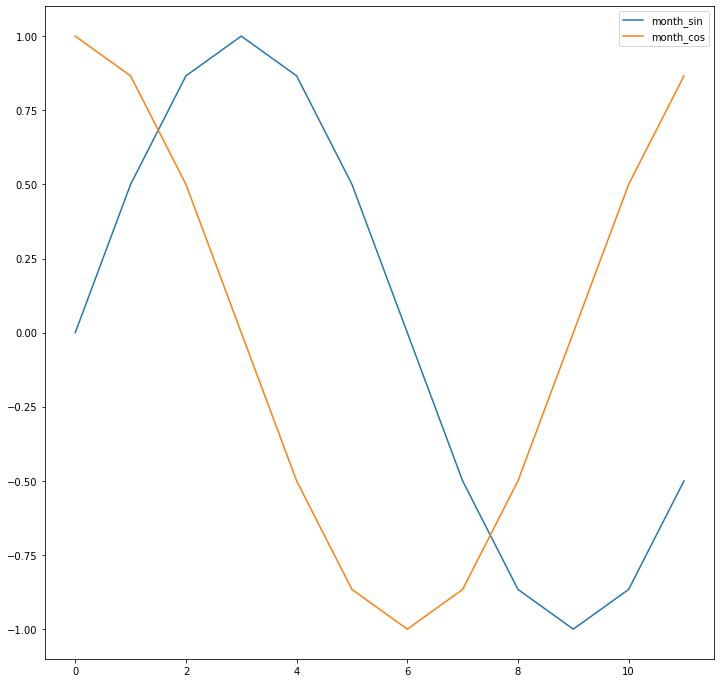

In [29]:
plt.plot(sin_transform(np.arange(0,12)), label='month_sin')
plt.plot(cos_transform(np.arange(0,12)), label='month_cos')
plt.legend()

## ACF

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import plotly_express as px
import plotly.graph_objects as go


def plot_line(acf):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(acf))), y=acf,
                        mode='lines',
                        name='acf'))
    fig.show()

In [31]:
train['store_item_id'] = train['store'].astype(str) + '_' + train['item'].astype(str)
train

,date,store,item,sales,store_item_id
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1
...,...,...,...,...,...
903865,2017-12-27,5,50,35,5_50
903866,2017-12-28,5,50,39,5_50
903867,2017-12-29,5,50,37,5_50
903868,2017-12-30,5,50,60,5_50


In [32]:
item_data = train[train['store_item_id'] == '1_1'].sort_values('date')
avg_data = train[['date', 'sales']].groupby('date').mean()
avg_data

,sales
date,
2013-01-01,28.404
2013-01-02,28.156
2013-01-03,29.964
2013-01-04,32.476
2013-01-05,33.104
...,...
2017-12-27,42.216
2017-12-28,45.084
2017-12-29,48.084


In [155]:
item_data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
118792,2013-01-01,2,20,-1.728516,2_20,1,1,2013,1,0.0,0.781738,0.623535,0.5,0.866211,0.201294,0.979492,0.306396,0.641602
118793,2013-01-02,2,20,-2.332031,2_20,2,1,2013,2,0.0,0.975098,-0.222534,0.5,0.866211,0.394287,0.918945,0.306396,0.641602
118794,2013-01-03,2,20,-2.029297,2_20,3,1,2013,3,0.0,0.433838,-0.900879,0.5,0.866211,0.571289,0.820801,0.306396,0.641602
118795,2013-01-04,2,20,-2.089844,2_20,4,1,2013,4,0.0,-0.433838,-0.900879,0.5,0.866211,0.724609,0.688965,0.306396,0.641602
118796,2013-01-05,2,20,-2.089844,2_20,5,1,2013,5,0.0,-0.975098,-0.222534,0.5,0.866211,0.848633,0.528809,0.306396,0.641602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120703,2018-03-27,2,20,NaN,2_20,1,3,2018,27,1.0,0.781738,0.623535,1.0,0.000000,-0.724609,0.688965,0.306396,0.641602
120704,2018-03-28,2,20,NaN,2_20,2,3,2018,28,1.0,0.975098,-0.222534,1.0,0.000000,-0.571289,0.820801,0.306396,0.641602
120705,2018-03-29,2,20,NaN,2_20,3,3,2018,29,1.0,0.433838,-0.900879,1.0,0.000000,-0.394287,0.918945,0.306396,0.641602
120706,2018-03-30,2,20,NaN,2_20,4,3,2018,30,1.0,-0.433838,-0.900879,1.0,0.000000,-0.201294,0.979492,0.306396,0.641602


In [33]:
#item_ac = acf(item_data['sales'], nlags=30)
item_ac = acf(item_data['sales'], nlags=366)
avg_ac = acf(avg_data['sales'], nlags=len(avg_data))
avg_ac

array([ 1.00000000e+00,  7.56530298e-01,  6.73320821e-01, ...,
        5.45643520e-04,  9.14544538e-05, -7.53840418e-05])

In [34]:
len(item_ac)

367

In [35]:
px.line(item_data, x='date', y='sales')

In [36]:
plot_line(item_ac)

In [37]:
plot_line(avg_ac)

In [38]:
important_lags = np.argsort(-avg_ac)[:100]
important_lags

array([  0,   7,  14,  21,  28,  35,   1,  42,   6, 364,   8,  49, 357,
       371,  13, 350,  15,   2, 378, 343,   5,  56,  20, 336,  22,   9,
       385,  12,  27, 329,  63,  29, 392,  16,   3,   4,  19, 322,  34,
       399,  23,  10,  36,  11,  70,  26, 315, 365, 406, 363,  41,  17,
        30,  18, 358,  43, 370, 356, 372,  33, 308,  77, 351, 413, 349,
        24, 377,  48,  25,  37, 344, 728, 379, 342, 366,  50, 735, 362,
       721, 301,  40, 337, 369, 359, 420, 335, 384, 714, 355,  31, 386,
        84,  32, 742, 373, 352,  55, 707,  44, 330])

In [39]:
sample_data = data[data['store_item_id'].isin(pd.Series(data['store_item_id'].unique()).sample(10))]

In [40]:
px.line(sample_data, x='date', y='sales', color='store_item_id', title='Store item sales')

## Normalize data

In [41]:
train['store_item_id'] = train['store'].astype(str) + '_' + train['item'].astype(str)
train

,date,store,item,sales,store_item_id
0,2013-01-01,1,1,13,1_1
1,2013-01-02,1,1,11,1_1
2,2013-01-03,1,1,14,1_1
3,2013-01-04,1,1,13,1_1
4,2013-01-05,1,1,10,1_1
...,...,...,...,...,...
903865,2017-12-27,5,50,35,5_50
903866,2017-12-28,5,50,39,5_50
903867,2017-12-29,5,50,37,5_50
903868,2017-12-30,5,50,60,5_50


## Training model

In [42]:
#mode = 'valid'
mode = 'test'

In [43]:
if mode == 'valid':
    scale_data = train[train['date'] < '2017-01-01']
else:
    scale_data = train[train['date'] >= '2014-01-01']

In [44]:
scale_data

,date,store,item,sales,store_item_id
365,2014-01-01,1,1,9,1_1
366,2014-01-02,1,1,14,1_1
367,2014-01-03,1,1,11,1_1
368,2014-01-04,1,1,20,1_1
369,2014-01-05,1,1,17,1_1
...,...,...,...,...,...
903865,2017-12-27,5,50,35,5_50
903866,2017-12-28,5,50,39,5_50
903867,2017-12-29,5,50,37,5_50
903868,2017-12-30,5,50,60,5_50


### Get yearly autocorrelation for each timeseries

In [45]:
def get_yearly_autocorr(data):
    ac = acf(data, nlags=366)
    return (0.5 * ac[365]) + (0.25 * ac[364]) + (0.25 * ac[366])

In [46]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scale_map = {}
scaled_data = pd.DataFrame()

import pickle

def save_scale_map(name, scale_map):
    with open(name + '.pickle', 'wb') as handle:
        pickle.dump(scale_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

for store_item_id, item_data in tqdm(data.groupby('store_item_id', as_index=False)):
    sidata = scale_data.loc[scale_data['store_item_id'] == store_item_id, 'sales']
    mu = sidata.mean()
    sigma = sidata.std()
    yearly_autocorr = get_yearly_autocorr(sidata)
    item_data.loc[:,'sales'] = (item_data['sales'] - mu) / sigma
    scale_map[store_item_id] = {'mu': mu, 'sigma': sigma}
    item_data['mean_sales'] = mu
    item_data['yearly_corr'] = yearly_autocorr
    scaled_data = pd.concat([scaled_data, item_data], ignore_index=True)

In [47]:
scaled_data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164136,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,8.660254e-01,2.012985e-01,0.979530,20.837098,0.310006
1,2013-01-02,1,1,-1.461219,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,8.660254e-01,3.943559e-01,0.918958,20.837098,0.310006
2,2013-01-03,1,1,-1.015594,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,8.660254e-01,5.712682e-01,0.820763,20.837098,0.310006
3,2013-01-04,1,1,-1.164136,1_1,4,1,2013,4,0.0,-0.433884,-0.900969,0.5,8.660254e-01,7.247928e-01,0.688967,20.837098,0.310006
4,2013-01-05,1,1,-1.609761,1_1,5,1,2013,5,0.0,-0.974928,-0.222521,0.5,8.660254e-01,8.486443e-01,0.528964,20.837098,0.310006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781831,0.623490,1.0,6.123234e-17,-7.247928e-01,0.688967,40.471595,0.362376
478996,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.974928,-0.222521,1.0,6.123234e-17,-5.712682e-01,0.820763,40.471595,0.362376
478997,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433884,-0.900969,1.0,6.123234e-17,-3.943559e-01,0.918958,40.471595,0.362376
478998,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433884,-0.900969,1.0,6.123234e-17,-2.012985e-01,0.979530,40.471595,0.362376


In [48]:
scaled_data['yearly_corr'] = ((scaled_data['yearly_corr'] - scaled_data['yearly_corr'].mean()) / scaled_data['yearly_corr'].std())
scaled_data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164136,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,8.660254e-01,2.012985e-01,0.979530,20.837098,-1.449892
1,2013-01-02,1,1,-1.461219,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,8.660254e-01,3.943559e-01,0.918958,20.837098,-1.449892
2,2013-01-03,1,1,-1.015594,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,8.660254e-01,5.712682e-01,0.820763,20.837098,-1.449892
3,2013-01-04,1,1,-1.164136,1_1,4,1,2013,4,0.0,-0.433884,-0.900969,0.5,8.660254e-01,7.247928e-01,0.688967,20.837098,-1.449892
4,2013-01-05,1,1,-1.609761,1_1,5,1,2013,5,0.0,-0.974928,-0.222521,0.5,8.660254e-01,8.486443e-01,0.528964,20.837098,-1.449892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781831,0.623490,1.0,6.123234e-17,-7.247928e-01,0.688967,40.471595,-0.513343
478996,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.974928,-0.222521,1.0,6.123234e-17,-5.712682e-01,0.820763,40.471595,-0.513343
478997,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433884,-0.900969,1.0,6.123234e-17,-3.943559e-01,0.918958,40.471595,-0.513343
478998,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433884,-0.900969,1.0,6.123234e-17,-2.012985e-01,0.979530,40.471595,-0.513343


In [49]:
scaled_data['mean_sales'] = (scaled_data['mean_sales'] - scaled_data['mean_sales'].mean()) / scaled_data['mean_sales'].std()
scaled_data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164136,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,8.660254e-01,2.012985e-01,0.979530,-1.394608,-1.449892
1,2013-01-02,1,1,-1.461219,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,8.660254e-01,3.943559e-01,0.918958,-1.394608,-1.449892
2,2013-01-03,1,1,-1.015594,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,8.660254e-01,5.712682e-01,0.820763,-1.394608,-1.449892
3,2013-01-04,1,1,-1.164136,1_1,4,1,2013,4,0.0,-0.433884,-0.900969,0.5,8.660254e-01,7.247928e-01,0.688967,-1.394608,-1.449892
4,2013-01-05,1,1,-1.609761,1_1,5,1,2013,5,0.0,-0.974928,-0.222521,0.5,8.660254e-01,8.486443e-01,0.528964,-1.394608,-1.449892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781831,0.623490,1.0,6.123234e-17,-7.247928e-01,0.688967,-0.614643,-0.513343
478996,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.974928,-0.222521,1.0,6.123234e-17,-5.712682e-01,0.820763,-0.614643,-0.513343
478997,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433884,-0.900969,1.0,6.123234e-17,-3.943559e-01,0.918958,-0.614643,-0.513343
478998,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433884,-0.900969,1.0,6.123234e-17,-2.012985e-01,0.979530,-0.614643,-0.513343


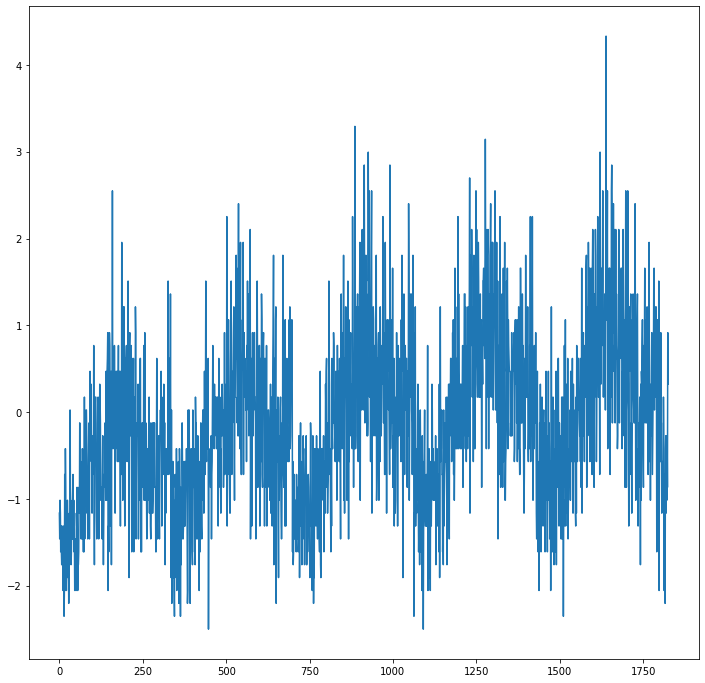

In [50]:
scaled_data.loc[scaled_data['store_item_id'] == '1_1', 'sales'].plot()

In [51]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [52]:
scaled_data.drop(['date','day', 'month', 'year', 'dayofweek', 'mean_sales', 'store_item_id'], axis=1)
scaled_data

,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164136,1_1,1,1,2013,1,0.0,0.781831,0.623490,0.5,8.660254e-01,2.012985e-01,0.979530,-1.394608,-1.449892
1,2013-01-02,1,1,-1.461219,1_1,2,1,2013,2,0.0,0.974928,-0.222521,0.5,8.660254e-01,3.943559e-01,0.918958,-1.394608,-1.449892
2,2013-01-03,1,1,-1.015594,1_1,3,1,2013,3,0.0,0.433884,-0.900969,0.5,8.660254e-01,5.712682e-01,0.820763,-1.394608,-1.449892
3,2013-01-04,1,1,-1.164136,1_1,4,1,2013,4,0.0,-0.433884,-0.900969,0.5,8.660254e-01,7.247928e-01,0.688967,-1.394608,-1.449892
4,2013-01-05,1,1,-1.609761,1_1,5,1,2013,5,0.0,-0.974928,-0.222521,0.5,8.660254e-01,8.486443e-01,0.528964,-1.394608,-1.449892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781831,0.623490,1.0,6.123234e-17,-7.247928e-01,0.688967,-0.614643,-0.513343
478996,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.974928,-0.222521,1.0,6.123234e-17,-5.712682e-01,0.820763,-0.614643,-0.513343
478997,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433884,-0.900969,1.0,6.123234e-17,-3.943559e-01,0.918958,-0.614643,-0.513343
478998,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433884,-0.900969,1.0,6.123234e-17,-2.012985e-01,0.979530,-0.614643,-0.513343


In [53]:
scaled_data = reduce_mem_usage(scaled_data)
scaled_data

Mem. usage decreased to 19.64 Mb (70.1% reduction)


,date,store,item,sales,store_item_id,dayofweek,month,year,day,year_mod,dayofweek_sin,dayofweek_cos,month_sin,month_cos,day_sin,day_cos,mean_sales,yearly_corr
0,2013-01-01,1,1,-1.164062,1_1,1,1,2013,1,0.0,0.781738,0.623535,0.5,0.866211,0.201294,0.979492,-1.394531,-1.450195
1,2013-01-02,1,1,-1.460938,1_1,2,1,2013,2,0.0,0.975098,-0.222534,0.5,0.866211,0.394287,0.918945,-1.394531,-1.450195
2,2013-01-03,1,1,-1.015625,1_1,3,1,2013,3,0.0,0.433838,-0.900879,0.5,0.866211,0.571289,0.820801,-1.394531,-1.450195
3,2013-01-04,1,1,-1.164062,1_1,4,1,2013,4,0.0,-0.433838,-0.900879,0.5,0.866211,0.724609,0.688965,-1.394531,-1.450195
4,2013-01-05,1,1,-1.609375,1_1,5,1,2013,5,0.0,-0.975098,-0.222534,0.5,0.866211,0.848633,0.528809,-1.394531,-1.450195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478995,2018-03-27,5,9,NaN,5_9,1,3,2018,27,1.0,0.781738,0.623535,1.0,0.000000,-0.724609,0.688965,-0.614746,-0.513184
478996,2018-03-28,5,9,NaN,5_9,2,3,2018,28,1.0,0.975098,-0.222534,1.0,0.000000,-0.571289,0.820801,-0.614746,-0.513184
478997,2018-03-29,5,9,NaN,5_9,3,3,2018,29,1.0,0.433838,-0.900879,1.0,0.000000,-0.394287,0.918945,-0.614746,-0.513184
478998,2018-03-30,5,9,NaN,5_9,4,3,2018,30,1.0,-0.433838,-0.900879,1.0,0.000000,-0.201294,0.979492,-0.614746,-0.513184


In [54]:
#scaled_data.drop().head()

In [55]:
scaled_data.to_pickle('./data/processed_data_test_stdscaler.pkl')
!ls -la ./data

total 37460
drwxr-xr-x 2 root root     4096 Aug 12 06:06 .
drwxr-xr-x 1 root root     4096 Aug 12 06:05 ..
-rw-r--r-- 1 root root 20036425 Aug 12 06:06 processed_data_test_stdscaler.pkl
-rw-r--r-- 1 root root   975309 Aug 12 06:05 test.csv
-rw-r--r-- 1 root root 17333449 Dec 15  2019 train.csv


In [56]:
!ls -la ./data

total 37460
drwxr-xr-x 2 root root     4096 Aug 12 06:06 .
drwxr-xr-x 1 root root     4096 Aug 12 06:05 ..
-rw-r--r-- 1 root root 20036425 Aug 12 06:06 processed_data_test_stdscaler.pkl
-rw-r--r-- 1 root root   975309 Aug 12 06:05 test.csv
-rw-r--r-- 1 root root 17333449 Dec 15  2019 train.csv


In [57]:
!ls -GFlash --color ./pytorch-ts/

total 6.0M
4.0K drwxr-xr-x 6 root 4.0K Aug 12 06:05  ./
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:05  ../
4.0K drwxr-xr-x 8 root 4.0K Aug 12 06:05  .git/
4.0K -rw-r--r-- 1 root 1.9K Aug 12 06:05  .gitignore
6.0M -rw-r--r-- 1 root 6.0M Aug 12 06:05 'item sales forecasting.ipynb'
 12K -rw-r--r-- 1 root  12K Aug 12 06:05  LICENSE.txt
4.0K -rw-r--r-- 1 root   89 Aug 12 06:05  README.md
4.0K -rw-r--r-- 1 root   43 Aug 12 06:05  requirements.txt
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05  torch_utils/
4.0K drwxr-xr-x 3 root 4.0K Aug 12 06:05  ts_models/
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05  ts_utils/


In [58]:
!ls -GFlash --color ./pytorch-ts/torch_utils/

total 28K
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:05 ./
4.0K drwxr-xr-x 6 root 4.0K Aug 12 06:05 ../
4.0K -rw-r--r-- 1 root 2.9K Aug 12 06:05 cocob.py
   0 -rw-r--r-- 1 root    0 Aug 12 06:05 __init__.py
4.0K -rw-r--r-- 1 root 2.6K Aug 12 06:05 predictor.py
 12K -rw-r--r-- 1 root  11K Aug 12 06:05 trainer.py


In [59]:
!python3 ./pytorch-ts/torch_utils/__init__.py --help
!cat ./pytorch-ts/torch_utils/__init__.py

In [60]:
!python3 ./pytorch-ts/torch_utils/cocob.py --help
!cat ./pytorch-ts/torch_utils/cocob.py

# %load cocob.py
import torch.optim as optim
import torch

###########################################################################
# Training Deep Networks without Learning Rates Through Coin Betting
# Paper: https://arxiv.org/abs/1705.07795
#
# NOTE: This optimizer is hardcoded to run on GPU, needs to be parametrized
###########################################################################

class COCOBBackprop(optim.Optimizer):
    
    def __init__(self, params, alpha=100, epsilon=1e-8, weight_decay=0):
        
        self._alpha = alpha
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        defaults = dict(alpha=alpha, epsilon=epsilon, weight_decay=weight_decay)
        super(COCOBBackprop, self).__init__(params, defaults)

    @torch.no_grad()  
    def step(self, closure=None):
        
        loss = None
        
        if closure is not None:
            loss = closure()
            
        for group in self.param_groups:
            for p in 

In [61]:
!python3 ./pytorch-ts/torch_utils/predictor.py --help
!cat ./pytorch-ts/torch_utils/predictor.py

import pathlib
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
np.random.seed(0)

class TorchPredictor():
    def __init__(self, name, model, preprocessor=None, postprocessor=None, device='cpu', **kwargs):
        self.model = model
        self.device = device
        self.name = name
        self.checkpoint_path = pathlib.Path(kwargs.get('checkpoint_folder', f'./models/{name}_chkpts'))
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        self.preprocessor = preprocessor
        self.postprocessor = postprocessor
        
    def _get_checkpoints(self, name=None):
        checkpoints = []
        checkpoint_path = self.checkpoint_path if name is None else pathlib.Path(kwargs.get('checkpoint_folder', f'./models/{name}_chkpts'))
        for cp in self.checkpoint_path.glob('checkpoint_*'):
            checkpoint_name = str(cp).split('/')[-1]
            checkpoint_epoch = int(checkpoint_name

In [62]:
!python3 ./pytorch-ts/torch_utils/trainer.py --help
!cat ./pytorch-ts/torch_utils/trainer.py

import pathlib
import numpy as np
import pandas as pd
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import tqdm
from tqdm.notebook import tqdm  
import pickle

def save_dict(path, name, _dict):
    with open(path/f'{name}.pickle', 'wb') as handle:
        pickle.dump(_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

class TorchTrainer():
    def __init__(self, name, model, optimizer, loss_fn, scheduler, device, **kwargs):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss_fn = loss_fn
        self.device = device
        self.name = name
        self.checkpoint_path = pathlib.Path(kwargs.get('checkpoint_folder', f'./models/{name}_chkpts'))
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        self.train_checkpoint_interval = kwargs.get('train_checkpoint_interval', 1)
        self.max_checkpoints = k

In [63]:
#!python3 ./pytorch-ts/ts_utils/sequence_builder.py --help
!cat ./pytorch-ts/ts_utils/sequence_builder.py 

#!mkdir ./sequence_data

import traceback
import tqdm
import numpy as np
import pandas as pd
from functools import partial
from tqdm.contrib.concurrent import process_map
from collections import defaultdict

tqdm.tqdm().pandas()

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col

In [64]:
#!pip install "tqdm==4.43.0"
!mkdir ./sequence_data
%run ./pytorch-ts/ts_utils/sequence_builder.py 

0it [00:00, ?it/s]


Mem. usage decreased to 19.64 Mb (0.0% reduction)


  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:17<00:00, 17.59s/it]



(411750, 7)


<Figure size 864x864 with 0 Axes>

In [65]:
!ls -la ./sequence_data/

total 1857620
drwxr-xr-x 2 root root       4096 Aug 12 06:21 .
drwxr-xr-x 1 root root       4096 Aug 12 06:06 ..
-rw-r--r-- 1 root root 1902189697 Aug 12 06:21 sequence_data_stdscaler_test.pkl


In [66]:
# due to a weird windows problem, multiprocessing cannot be run in notebook
# Run sequence builder on scaled_data, and load the pickle here
sequence_data = pd.read_pickle('./sequence_data/sequence_data_stdscaler_test.pkl')
sequence_data.shape

(411750, 7)

## Prepare pytorch dataloader

In [67]:
from torch.utils.data import Dataset, DataLoader

In [68]:
class StoreItemDataset(Dataset):
    def __init__(self, cat_columns=[], num_columns=[], embed_vector_size=None, decoder_input=True, ohe_cat_columns=False):
        super().__init__()
        self.sequence_data = None
        self.cat_columns = cat_columns
        self.num_columns = num_columns
        self.cat_classes = {}
        self.cat_embed_shape = []
        self.cat_embed_vector_size = embed_vector_size if embed_vector_size is not None else {}
        self.pass_decoder_input=decoder_input
        self.ohe_cat_columns = ohe_cat_columns
        self.cat_columns_to_decoder = False

    def get_embedding_shape(self):
        return self.cat_embed_shape

    def load_sequence_data(self, processed_data):
        self.sequence_data = processed_data

    def process_cat_columns(self, column_map=None):
        column_map = column_map if column_map is not None else {}
        for col in self.cat_columns:
            self.sequence_data[col] = self.sequence_data[col].astype('category')
            if col in column_map:
                self.sequence_data[col] = self.sequence_data[col].cat.set_categories(column_map[col]).fillna('#NA#')
            else:
                self.sequence_data[col].cat.add_categories('#NA#', inplace=True)
            self.cat_embed_shape.append((len(self.sequence_data[col].cat.categories), self.cat_embed_vector_size.get(col, 50)))
    
    def __len__(self):
        return len(self.sequence_data)

    def __getitem__(self, idx):
        row = self.sequence_data.iloc[[idx]]
        x_inputs = [torch.tensor(row['x_sequence'].values[0], dtype=torch.float32)]
        y = torch.tensor(row['y_sequence'].values[0], dtype=torch.float32)
        if self.pass_decoder_input:
            decoder_input = torch.tensor(row['y_sequence'].values[0][:, 1:], dtype=torch.float32)
        if len(self.num_columns) > 0:
            for col in self.num_columns:
                num_tensor = torch.tensor([row[col].values[0]], dtype=torch.float32)
                x_inputs[0] = torch.cat((x_inputs[0], num_tensor.repeat(x_inputs[0].size(0)).unsqueeze(1)), axis=1)
                decoder_input = torch.cat((decoder_input, num_tensor.repeat(decoder_input.size(0)).unsqueeze(1)), axis=1)
        if len(self.cat_columns) > 0:
            if self.ohe_cat_columns:
                for ci, (num_classes, _) in enumerate(self.cat_embed_shape):
                    col_tensor = torch.zeros(num_classes, dtype=torch.float32)
                    col_tensor[row[self.cat_columns[ci]].cat.codes.values[0]] = 1.0
                    col_tensor_x = col_tensor.repeat(x_inputs[0].size(0), 1)
                    x_inputs[0] = torch.cat((x_inputs[0], col_tensor_x), axis=1)
                    if self.pass_decoder_input and self.cat_columns_to_decoder:
                        col_tensor_y = col_tensor.repeat(decoder_input.size(0), 1)
                        decoder_input = torch.cat((decoder_input, col_tensor_y), axis=1)
            else:
                cat_tensor = torch.tensor(
                    [row[col].cat.codes.values[0] for col in self.cat_columns],
                    dtype=torch.long
                )
                x_inputs.append(cat_tensor)
        if self.pass_decoder_input:
            x_inputs.append(decoder_input)
            y = torch.tensor(row['y_sequence'].values[0][:, 0], dtype=torch.float32)
        if len(x_inputs) > 1:
            return tuple(x_inputs), y
        return x_inputs[0], y

In [69]:
sequence_data.head()

,store_item_id,x_sequence,y_sequence,date,item,store,yearly_corr
0,1_1,"[[-1.164, 0.7817, 0.6235, 0.5, 0.866, 0.0, 0.2...","[[0.4697, -0.7817, 0.6235, 0.0, -1.0, 0.0, -0....",2013-06-30,1,1,-1.450195
1,1_1,"[[-1.461, 0.975, -0.2225, 0.5, 0.866, 0.0, 0.3...","[[0.3213, 0.0, 1.0, -0.5, -0.866, 0.0, 0.2013,...",2013-07-01,1,1,-1.450195
2,1_1,"[[-1.016, 0.4338, -0.901, 0.5, 0.866, 0.0, 0.5...","[[-0.57, 0.7817, 0.6235, -0.5, -0.866, 0.0, 0....",2013-07-02,1,1,-1.450195
3,1_1,"[[-1.164, -0.4338, -0.901, 0.5, 0.866, 0.0, 0....","[[-1.3125, 0.975, -0.2225, -0.5, -0.866, 0.0, ...",2013-07-03,1,1,-1.450195
4,1_1,"[[-1.609, -0.975, -0.2225, 0.5, 0.866, 0.0, 0....","[[0.4697, 0.4338, -0.901, -0.5, -0.866, 0.0, 0...",2013-07-04,1,1,-1.450195


In [70]:
lag_null_filter = sequence_data['y_sequence'].apply(lambda val: np.isnan(val[:, -1].reshape(-1)).sum() == 0)

In [71]:
sequence_data.loc[lag_null_filter, 'date'].min()

Timestamp('2014-01-02 00:00:00')

Validation scheme

- Validation Model is trained on 2014 to 2016 data and predict 1st 3 months of 2017 data.
- The best performing model will be trained on 2014 to 2017 data to predict first 3 months of 2018, without validation

In the validation model, sequences of the last 3 months of 2016 shouldn't be included because it contains 2017 values in y

In [72]:
test_sequence_data = sequence_data[sequence_data['date'] == '2018-01-01']

In [73]:
# data after 10th month will have prediction data in y_sequence
if mode == 'test':
    train_sequence_data = sequence_data[(sequence_data['date'] <= '2017-10-01') & ((sequence_data['date'] >= '2014-01-02'))]
    valid_sequence_data = pd.DataFrame()
else:    
    train_sequence_data = sequence_data[(sequence_data['date'] <= '2016-10-01') & (sequence_data['date'] >= '2014-01-02')]
    valid_sequence_data = sequence_data[(sequence_data['date'] > '2016-10-01') & (sequence_data['date'] <= '2017-01-01')]

In [74]:
print(train_sequence_data.shape, valid_sequence_data.shape, test_sequence_data.shape)

(342250, 7) (0, 0) (250, 7)


In [75]:
train_dataset = StoreItemDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'], embed_vector_size={'store': 4, 'item': 4}, ohe_cat_columns=True)
valid_dataset = StoreItemDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'], embed_vector_size={'store': 4, 'item': 4}, ohe_cat_columns=True)
test_dataset = StoreItemDataset(cat_columns=['store', 'item'], num_columns=['yearly_corr'], embed_vector_size={'store': 4, 'item': 4}, ohe_cat_columns=True)

In [76]:
train_dataset.load_sequence_data(train_sequence_data)
valid_dataset.load_sequence_data(valid_sequence_data)
test_dataset.load_sequence_data(test_sequence_data)

In [77]:
cat_map = train_dataset.process_cat_columns()

In [78]:
if mode == 'valid':
    valid_dataset.process_cat_columns(cat_map)
test_dataset.process_cat_columns(cat_map)

In [79]:
batch_size = 256

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
print(len(train_dataloader), len(valid_dataloader))

1337 0


In [80]:
(X_con, X_dec), y = next(iter(train_dataloader))
X_con.shape, y.shape, X_dec.shape

(torch.Size([256, 180, 66]), torch.Size([256, 90]), torch.Size([256, 90, 9]))

## Encoder Decoder model

In [81]:
!ls -la ./pytorch-ts/

total 6112
drwxr-xr-x 6 root root    4096 Aug 12 06:05  .
drwxr-xr-x 1 root root    4096 Aug 12 06:06  ..
drwxr-xr-x 8 root root    4096 Aug 12 06:05  .git
-rw-r--r-- 1 root root    1861 Aug 12 06:05  .gitignore
-rw-r--r-- 1 root root 6208488 Aug 12 06:05 'item sales forecasting.ipynb'
-rw-r--r-- 1 root root   11357 Aug 12 06:05  LICENSE.txt
-rw-r--r-- 1 root root      89 Aug 12 06:05  README.md
-rw-r--r-- 1 root root      43 Aug 12 06:05  requirements.txt
drwxr-xr-x 2 root root    4096 Aug 12 06:05  torch_utils
drwxr-xr-x 3 root root    4096 Aug 12 06:05  ts_models
drwxr-xr-x 2 root root    4096 Aug 12 06:05  ts_utils


In [82]:
!ls -la ./pytorch-ts/ts_models/

total 28
drwxr-xr-x 3 root root 4096 Aug 12 06:05 .
drwxr-xr-x 6 root root 4096 Aug 12 06:05 ..
-rw-r--r-- 1 root root 1712 Aug 12 06:05 decoders.py
-rw-r--r-- 1 root root 1816 Aug 12 06:05 encoder_decoder.py
-rw-r--r-- 1 root root 5225 Aug 12 06:05 encoders.py
-rw-r--r-- 1 root root    0 Aug 12 06:05 __init__.py
drwxr-xr-x 2 root root 4096 Aug 12 06:05 model_utils


In [83]:
import sys
sys.path.append('/content/pytorch-ts/ts_models/')

!python3 ./pytorch-ts/ts_models/decoders.py --help
!python3 ./pytorch-ts/ts_models/encoder_decoder.py --help
!python3 ./pytorch-ts/ts_models/encoders.py --help
!python3 ./pytorch-ts/ts_models/model_utils/utils.py --help

import encoders
import decoders
import encoder_decoder

In [84]:
!ls -la ./pytorch-ts/torch_utils/

total 28
drwxr-xr-x 2 root root  4096 Aug 12 06:05 .
drwxr-xr-x 6 root root  4096 Aug 12 06:05 ..
-rw-r--r-- 1 root root  2880 Aug 12 06:05 cocob.py
-rw-r--r-- 1 root root     0 Aug 12 06:05 __init__.py
-rw-r--r-- 1 root root  2622 Aug 12 06:05 predictor.py
-rw-r--r-- 1 root root 10725 Aug 12 06:05 trainer.py


In [85]:
import sys
sys.path.append('/content/pytorch-ts/torch_utils/')

!python3 ./pytorch-ts/torch_utils/cocob.py --help
!python3 ./pytorch-ts/torch_utils/predictor.py --help
!python3 ./pytorch-ts/torch_utils/trainer.py --help

import cocob
import predictor
import trainer

In [86]:
!pip install torchcontrib

  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7533 sha256=b79267fdd365988d96a04d64f4e48514bb70c4259b5477b14380d9ddf6c3e97e
  Stored in directory: /root/.cache/pip/wheels/91/58/d0/f03811c3e34e1f14031294b5f30d8693689972af874d1225b8
Successfully built torchcontrib


In [87]:
#
import torch.nn as nn
import torch.optim as optim

#from ts_models.encoders import RNNEncoder, RNNConcatEncoder, RNNInitEncoder
#from ts_models.decoders import DecoderCell, AttentionDecoderCell
#from ts_models.encoder_decoder import EncoderDecoderWrapper
#from ts_models.encoder_decoder_attention import EncoderDecoderAttentionWrapper
#from torch_utils.cocob import COCOBBackprop
#from torch_utils.trainer import TorchTrainer


import encoders
import decoders
import encoder_decoder

import torchcontrib

torch.manual_seed(420)
np.random.seed(420)

In [88]:
def smape_loss(y_pred, y_true):
    denominator = (y_true + y_pred) / 200.0
    diff = torch.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return torch.mean(diff)

def smape_exp_loss(y_pred, y_true):
    y_pred = y_pred.cpu().numpy()
    y_true = y_true.cpu().numpy()
    y_pred = np.expm1(y_pred)
    y_true = np.expm1(y_true)
    denominator = (y_true + y_pred) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

def differentiable_smape_loss(y_pred, y_true):
    epsilon = 0.1
    summ = torch.max(torch.abs(y_true) + torch.abs(y_pred) + epsilon, torch.tensor(0.5 + epsilon, device='cuda'))
    smape = torch.abs(y_pred - y_true) / summ
    return torch.mean(smape)

In [89]:
device = 'cuda'

encoder = encoders.RNNEncoder(
    #input_feature_len=71, 
    input_feature_len=66, 
    rnn_num_layers=1, 
    hidden_size=100,  
    sequence_len=180,
    bidirectional=False,
    device=device,
    rnn_dropout=0.2
)

decoder_cell = decoders.DecoderCell(
    input_feature_len=10,
    hidden_size=100,
)


#loss_function = differentiable_smape_loss
#loss_function = differentiable_smape_loss
loss_function = nn.MSELoss()
#loss_function = nn.SmoothL1Loss()
# encoder_optimizer = COCOBBackprop(encoder.parameters(), weight_decay=0)
# decoder_optimizer = COCOBBackprop(decoder_cell.parameters(), weight_decay=0)
# encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=2e-3, weight_decay=1e-)
# decoder_optimizer = torch.optim.AdamW(decoder_cell.parameters(), lr=2e-3, weight_decay=1e-1)



encoder = encoder.to(device)
decoder_cell = decoder_cell.to(device)

model = encoder_decoder.EncoderDecoderWrapper(
    encoder,
    decoder_cell,
    output_size=90,
    teacher_forcing=0,
    sequence_len=180,
    decoder_input=True,
    device='cuda'
)

model = model.to(device)

encoder_optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-3, weight_decay=1e-2)
decoder_optimizer = torch.optim.AdamW(decoder_cell.parameters(), lr=1e-3, weight_decay=1e-2)

encoder_scheduler = optim.lr_scheduler.OneCycleLR(encoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)
decoder_scheduler = optim.lr_scheduler.OneCycleLR(decoder_optimizer, max_lr=1e-3, steps_per_epoch=len(train_dataloader), epochs=6)

model_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-2)
#scheduler = optim.lr_scheduler.OneCycleLR(model_optimizer, max_lr=3e-3, steps_per_epoch=len(train_dataloader), epochs=6)

In [90]:
xb, yb = next(iter(train_dataloader))
xb = [xbi.to(device) for xbi in xb]
yb = yb.to(device)
model(xb, yb).shape

torch.Size([256, 180, 100])
torch.Size([1, 256, 100])


torch.Size([256, 90])

In [91]:
trainer = trainer.TorchTrainer(
    'encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam',
    model, 
    [encoder_optimizer, decoder_optimizer], 
    loss_function, 
    [encoder_scheduler, decoder_scheduler],
    device, 
    scheduler_batch_step=True,
    pass_y=True,
    #additional_metric_fns={'SMAPE': smape_exp_loss}
)

torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


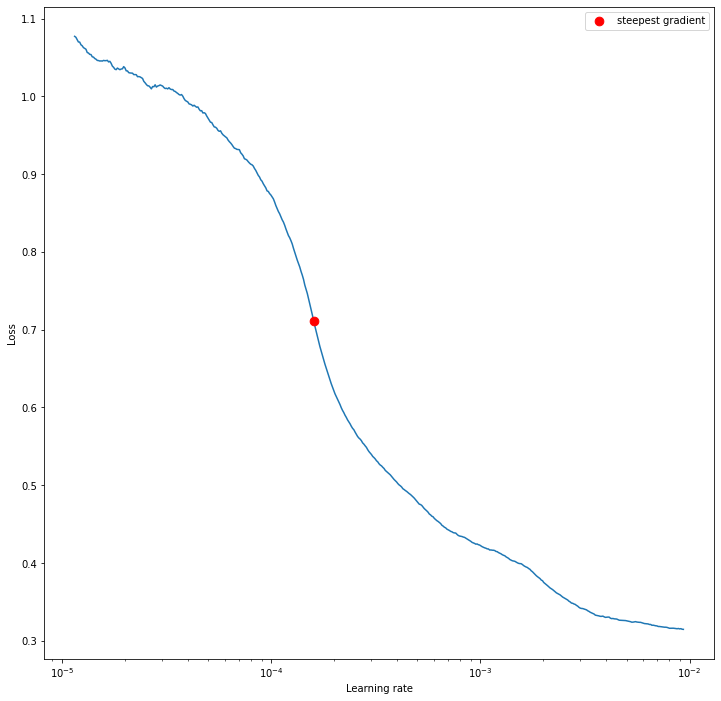

In [92]:
trainer.lr_find(train_dataloader, model_optimizer, start_lr=1e-5, end_lr=1e-2, num_iter=500)

In [93]:
vd = valid_dataloader if mode == 'valid' else None
trainer.train(6, train_dataloader, vd, resume_only_model=True, resume=True)

torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])
torch.Size([1, 256, 100])
torch.Size([256, 180, 100])


In [94]:
# My hipothesis: Don't work with empty data - valid_sequence_data.shape (0, 0)

#vd = valid_dataloader if mode == 'valid' else None
#trainer.train(6, train_dataloader, vd, resume_only_model=True, resume=True)

In [95]:
trainer._load_checkpoint(only_model=True)

loaded checkpoint for epoch - 6


6

In [96]:
trainer._load_best_checkpoint()

In [97]:
if mode == 'valid':
    valid_predictions = trainer.predict(valid_dataloader)

In [98]:
test_predictions = trainer.predict(test_dataloader)

torch.Size([250, 180, 100])
torch.Size([1, 250, 100])



In [106]:
test_predictions

array([[-1.3013345 , -0.95864034, -0.9301263 , ...,  0.025062  ,
         0.2715559 ,  0.5005769 ],
       [-1.4915649 , -1.1088682 , -1.1055803 , ..., -0.02040568,
         0.2601726 ,  0.5379669 ],
       [-1.4656341 , -1.1170356 , -1.1141075 , ..., -0.02104528,
         0.2685129 ,  0.546022  ],
       ...,
       [-1.4607283 , -1.0426128 , -1.03309   , ..., -0.00989981,
         0.25664002,  0.51840943],
       [-1.475302  , -1.0750488 , -1.0653841 , ..., -0.016516  ,
         0.25832897,  0.52849597],
       [-1.425523  , -1.0133111 , -1.0141383 , ..., -0.01663934,
         0.2434477 ,  0.50346476]], dtype=float32)

In [99]:
valid_sequence_data.index = range(len(valid_sequence_data))
test_sequence_data.index = range(len(test_sequence_data))

In [100]:
if mode == 'valid':
    valid_sequence_data['predictions'] = pd.Series(valid_predictions.tolist())
test_sequence_data['predictions'] = pd.Series(test_predictions.tolist())

In [101]:
if mode == 'valid':
    valid_sequence_data['X'] = valid_sequence_data['x_sequence'].apply(lambda x: x[:, 0])
    valid_sequence_data['Y'] = valid_sequence_data['y_sequence'].apply(lambda x: x[:, 0])

### Rescale data

In [102]:
def rescale_data(scale_map, data_df, columns=['predictions', 'y_sequence', 'x_sequence']):
    rescaled_data = pd.DataFrame()
    for store_item_id, item_data in tqdm(data_df.groupby('store_item_id', as_index=False)):
        mu = scale_map[store_item_id]['mu']
        sigma = scale_map[store_item_id]['sigma']
        for col in columns:
            item_data[col] = item_data[col].apply(lambda x: (np.array(x) * sigma) + mu)
        rescaled_data = pd.concat([rescaled_data, item_data], ignore_index=True)
    return rescaled_data

In [147]:
# My hipothesis: Don't work with empty data - valid_sequence_data.shape (0, 0)

#if mode == 'valid':
#    valid_rescaled = rescale_data(scale_map, valid_sequence_data, columns=['X', 'Y', 'predictions'])
#test_rescaled = rescale_data(scale_map, test_sequence_data, columns=['predictions'])

In [ ]:
print(valid_sequence_data.shape)
print(test_sequence_data.shape)

In [145]:
# My hipothesis: Don't work with empty data - valid_sequence_data.shape (0, 0)

#if mode == 'valid':
#    valid_sequence_data = valid_rescaled
#test_sequence_data = test_rescaled

## Results Analysis

In [113]:
valid_sequence_data.head()

""


In [114]:
import plotly_express as px
import plotly.graph_objects as go


def plot_sequence_row(row):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(180)), y=row['X'],
                        mode='lines',
                        name='past data'))
    fig.add_trace(go.Scatter(x=list(range(180, 270)), y=row['Y'],
                        mode='lines',
                        name='actual'))
    fig.add_trace(go.Scatter(x=list(range(180, 270)), y=row['predictions'],
                        mode='lines',
                        name='predictions'))
    fig.show()

In [146]:
#valid_sequence_data['predictions'] = valid_sequence_data['predictions'].apply(np.array)

In [116]:
def get_col_mean(group_data):
    agg_data = {}
    for col in group_data.columns:
        if col == 'date':
            continue
        agg_data[col] = group_data[col].mean()
    return pd.Series(agg_data)

In [ ]:
# My hipothesis: Don't work with empty data - valid_sequence_data.shape (0, 0)

#date_predictions = valid_sequence_data[['X', 'Y', 'predictions', 'date']].groupby('date').apply(get_col_mean)

In [ ]:
# My hipothesis: Don't work with empty data - valid_sequence_data.shape (0, 0)

#plot_sequence_row(date_predictions.iloc[-1])

## Get Results

In [119]:
def generate_flat_df(sequence_data, predict_col='predictions', actual_col='Y'):
    flat_df = pd.DataFrame()
    for i, row in sequence_data.iterrows():
        row_df = pd.DataFrame()
        start_date = row['date']
        row_df['date'] = pd.date_range(start_date, periods=90).date.tolist()
        row_df['store'] = row['store']
        row_df['item'] = row['item']
        row_df['predictions'] = row[predict_col]
        if actual_col:
            row_df['sales'] = row[actual_col]
        flat_df = pd.concat([flat_df, row_df], ignore_index=False)
    flat_df.index = range(len(flat_df))
    flat_df['date'] = pd.to_datetime(flat_df['date'])
    return flat_df

In [120]:
if mode == 'valid':
    valid_sequence_data_sample = valid_sequence_data[valid_sequence_data['date'] == '2017-01-01']
    valid_predict_df = generate_flat_df(valid_sequence_data_sample)

In [123]:
test_predict_df = generate_flat_df(test_sequence_data, actual_col=None)
test_predict_df

,date,store,item,predictions
0,2018-01-01,1,1,-1.301335
1,2018-01-02,1,1,-0.958640
2,2018-01-03,1,1,-0.930126
3,2018-01-04,1,1,-0.790154
4,2018-01-05,1,1,-0.616131
...,...,...,...,...
22495,2018-03-27,5,9,-0.228678
22496,2018-03-28,5,9,-0.235856
22497,2018-03-29,5,9,-0.016639
22498,2018-03-30,5,9,0.243448


In [124]:
def smape(y_pred, y_true):
    denominator = (y_true + y_pred) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [125]:
if mode == 'valid':
    smape(valid_predict_df['predictions'], valid_predict_df['sales'])

In [126]:
if mode == 'valid':
    smape(np.round(valid_predict_df['predictions']), valid_predict_df['sales'])

## Plot forecast

In [127]:
item_data = data[data['store_item_id'] == '2_20']
item_forecast = test_predict_df[(test_predict_df['store'] == 2) & (test_predict_df['item'] == 20)]

In [128]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=item_data['date'], y=item_data['sales'],
                    mode='lines',
                    name='past data'))
fig.add_trace(go.Scatter(x=item_forecast['date'], y=item_forecast['predictions'],
                    mode='lines',
                    name='forecast'))
fig.show()

## Get submission file

In [129]:
test_predict_df = test_predict_df.merge(test, on=['date', 'store', 'item'])

In [130]:
test_predict_df.sort_values('id').head()

,date,store,item,predictions,id,sales
0,2018-01-01,1,1,-1.301335,0,NaN
1,2018-01-02,1,1,-0.958640,1,NaN
2,2018-01-03,1,1,-0.930126,2,NaN
3,2018-01-04,1,1,-0.790154,3,NaN
4,2018-01-05,1,1,-0.616131,4,NaN


In [131]:
test_predict_df['predictions'] = np.round(test_predict_df['predictions'])

In [132]:
def save_results(df, name):
    df[['id', 'predictions']].rename(columns={'predictions': 'sales'}).sort_values('id').to_csv(f'./results/{name}.csv', index=False)

In [140]:
!ls -GFlash --color ./

total 3.5M
4.0K drwxr-xr-x 1 root 4.0K Aug 12 07:34 ./
4.0K drwxr-xr-x 1 root 4.0K Aug 12 06:03 ../
4.0K drwxr-xr-x 4 root 4.0K Jul 16 13:19 .config/
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:06 data/
4.0K drwxr-xr-x 3 root 4.0K Aug 12 06:22 models/
4.0K drwxr-xr-x 6 root 4.0K Aug 12 06:05 pytorch-ts/
4.0K drwxr-xr-x 2 root 4.0K Aug 12 07:34 result/
4.0K drwxr-xr-x 3 root 4.0K Aug 12 06:22 runs/
4.0K drwxr-xr-x 1 root 4.0K Jul 16 13:20 sample_data/
388K -rw-r--r-- 1 root 385K Aug 12 06:05 sample_submission.csv
4.0K drwxr-xr-x 2 root 4.0K Aug 12 06:21 sequence_data/
3.1M -rw-r--r-- 1 root 3.1M Aug 12 06:05 train.csv.zip


In [142]:
!mkdir results
save_results(test_predict_df, 'encdec_ohe_std_mse_wd1e-2_do2e-1_test_hs100_tf0_adam_round_day')

THE END